# IEEE SPS Seasonal School on Networked Federated Learning 
# https://ieeespcasfinland.github.io/
# Exericse 2 

Networked federated learning uses datasets with an intrinsic network structure. We can conveniently represent networked collections of local datasets by an undirected weighted graph, which we refer to as an empirical graph. The nodes of an empirical graph are numbered by a natural number $i=0,1,\ldots$. 
Each node $i=0,1,\ldots$ of an empirical graph represents a local dataset which consists of several individual data points. 

Different local datasets are related by some notion of similarity that is represented by a set $\mathcal{E}$ of undirected edges. For two similar data sets, connected by an edge $\{i,j\}$, we quantify their similarity by a positive edge weight $A_{ij}>0$. The neighborhood $\mathcal{N}(i)$ of a node $i$ is the set of all other nodes $j$ that are connected with node $i$ by and edge $\{i,j\}$. The degree $d_{i}:=|\mathcal{N}(i)|$ of a node $i$ is the number of its neighbours.  

To summarize, an empirical graph is an object that represents a collection of local datasets along with their similarities. We will use an empirical grpah not only to represent networked data but also the corresponding networked models. In particular, each node in an empirical graph will be assigned a model parameter that can be tuned based on training data. 

The Python package `networkx` provides convenient means for storing and manipulating networked data and models. We will demonstrate how to generate and process an empirical graph using the class `networkx.Graph` and its methods. 

The code snippet below generates a `networkx.graph` object that represents networked data.

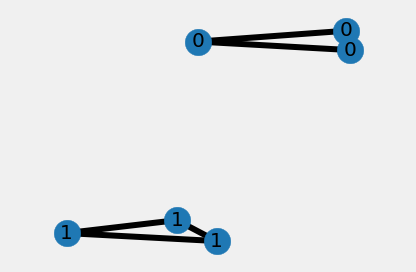

In [38]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

G.add_nodes_from(range(6))  # add six nodes i=0,..,5 to the graph G. 

# assign nodes i=0,1,2 to block 0 

G.node[0]["block"] = 0 
G.node[1]["block"] = 0 
G.node[2]["block"] = 0 

# assign nodes i=3,4,5 to block 1

G.node[3]["block"] = 1 
G.node[4]["block"] = 1 
G.node[5]["block"] = 1 


# add egdes (i,j) along with a weight A_ij 

#intra-cluster edges for block 0 
G.add_edge(0, 1, weight=0.6)
G.add_edge(0, 2, weight=0.7)
G.add_edge(1, 2, weight=0.6)

#inter-cluster edge between block 0 and 1 
#G.add_edge(2, 3, weight=0.0)

# intra-cluster edges for block 1 
G.add_edge(3, 4, weight=0.7)
G.add_edge(4, 5, weight=0.9)
G.add_edge(3, 5, weight=0.6)


# determine the edges whose weight is smaller than 1/2
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
# determine the edges whose weight is larger or equal than 1/2 
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

# determine convenient coordinates for illustrating nodes in a plane
pos = nx.spring_layout(G, seed=7)  

# draw the nodes of the network 
nx.draw_networkx_nodes(G, pos, node_size=700)

# draw the edges with large weights using solid lines  
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)

# draw the edges with small weights using dashed lines 
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)


# draw the node names 
nx.draw_networkx_labels(G, pos, nx.get_node_attributes(G, 'block'), font_size=20, font_family="sans-serif")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

## Network Averaging 

The above code snippet generated an undirected graph stored in the networkx object `G`. The graph consists of nodes $i=0,\ldots,m-1$. The code snippet below assigns to each node $i$ the numeric attribute $y^{(i)}$ to each node  We denote the attribute value of node `i` as `y[i]`. We then demonstrate how to compute the average 
$$ (1/m) \sum_{i=0}^{m-1} y[i]$$ 
of all node values `y[i]` using an simple network averaging method that we describe next.

Let us collect the attributes $y^{(i)}$ into the vector $\mathbf{y}^{(0)} = \big(y[0],\ldots,y[5]\big)^{T}$. We then construct a sequence of vectors by iterating the update 
\begin{equation}
        \mathbf{y}^{(r)} = \mathbf{W}^{({\rm MH})} \mathbf{y}^{(r-1)} \mbox{, for } r=1,\ldots,N_{\rm AV}.   \quad \quad {\rm (MHUpdate)}
\end{equation}
Here, we used the matrix $\mathbf{W}^{({\rm MH})}$ defines element-wise as
\begin{equation}
\big( \mathbf{W}^{({\rm MH})} \big)_{i,j} := \begin{cases} 1/\big({\rm max} \{d_{i},d_{j} \}+1 \big) & \mbox{, for } \{i,j\} \in \mathcal{E} \\
1 - \sum_{j \in \mathcal{N}(i)} \big( \mathbf{W}^{({\rm MH})} \big)_{i,j} & \mbox{, for } i=j \\ 
0  & \mbox{ otherwise. } \end{cases}
\end{equation} 

It turns out that the update (MHUpdate) can be implemented as message passing over the empirical graph. Indeed, during the udpate (MHUpdate) each node requires information (results of previous iterations) only from its neighbours. Based on the received information, each node $i$ perfoms local computations to update its local information (stored in entry $y_{i}^{(k)}$. This updated local information is then forwarded to the neighbours of $i$ in the next iteration. This message passing rounds (iterations) are repeated for a sufficient number of times (determined by the convergence speed of (MHUpdate)).   

More details about this network averaging algorithm can be found in 
https://web.stanford.edu/~boyd/papers/pdf/avg_metropolis.pdf

In [39]:
import numpy as np 

samplesize=4
true_w = np.random.randn(2)
    
for node_dmy in G.nodes: 
   G.nodes[node_dmy]["y"] = 0.2*np.random.randn(1)+3

In [40]:
#for node_dmy in G.nodes: 
#    print(G.nodes[node_dmy]["y"])

#for edge_dmy in G.edges: 
#    print(G.edges[edge_dmy]["weight"])
 

## the following code creates a numpy array W_MH that stores 
## Metropolis-Hastings weights for a network averaging algorithm 
## The entris W_MH[i,j] is the weight by which the attribute of node j 
## will be taken into account for the update of the attribute at node i 

nrnodes = len(G.nodes)
W_MH = np.zeros((nrnodes,nrnodes)) 

# loop over all edges in G.edges ()  
for edge in G.edges(): 
    # store first node of this edge in variable "node_a"
    node_a = edge[0]
    # store second node of this edge in variable "node_b"
    node_b = edge[1]
    # set entry W_MH[node_a,node_b] and W_MH[node_b,node_a] to MH weight  
    W_MH[node_a,node_b] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)
    W_MH[node_b,node_a] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)

# loop over all nodes in the contact network G
for nodedmy in G.nodes(): 
    # set weights W[nodedmy,nodedmy] to 1 - sum of weights for all neighbors of nodedmy
    W_MH[nodedmy,nodedmy] = 1-np.sum(W_MH[nodedmy,:])

In [41]:
# loop over iterations for computing average 

nriters = 10

for iterdmy in range(nriters):
    # read in current values of "y" for each node and store in numpy array `graphsigold`
    oldvalues = np.fromiter(nx.get_node_attributes(G,'y').values(),dtype=float, count=nrnodes)
    
    # loop over all nodes in "G", use loop variable "node_i"
    for node_i in G.nodes(data=False):
        # set auxiliary variable "tmp" to 0 
        dmy = 0 
        #determine neighbors of node_i 
        neighborhood = G[node_i]
        # loop over all neighbours of current node "node_i"
        for node_j in neighborhood: 
             dmy = dmy+W_MH[node_i,node_j]*oldvalues[node_j]#/(fac1*fac2)
        G.node[node_i]['y'] =W_MH[node_i,node_i]*oldvalues[node_i] + dmy

In [42]:
# print out the attribute values for each node after network averaging 

for node_i in G.nodes(data=True): 
    print(node_i)

(0, {'block': 0, 'y': 3.041009292045686})
(1, {'block': 0, 'y': 3.041009292045686})
(2, {'block': 0, 'y': 3.041009292045686})
(3, {'block': 1, 'y': 2.9825990788002903})
(4, {'block': 1, 'y': 2.9825990788002903})
(5, {'block': 1, 'y': 2.9825990788002903})


## A First Federated Learning Algorithm 

The code snippet above demonstrated how to compute the average of a networked dataset that consists of a single number that is assigned to each node. Let us now consider a more interesting network dataset where each node `i` carries a local dataset that consists of several data points. The $r$-th data point assigned to node `i` is characterized by a numeric feature vector $\mathbf{x}^{(i,r)} \in \mathbb{R}^{n}$ and a numeric label value $y^{(i,r)}$. We collect the feature vectors and label values into the feature matrix 
$$\mathbf{X}^{(i)} = \big(\mathbf{x}^{(i,1)},\ldots,\mathbf{x}^{(i,m_{i})} \big)^{T} \mbox{ , and } \mathbf{y}^{(i)} = \big(\mathbf{y}^{(i,1)},\ldots,\mathbf{y}^{(i,m_{i})} \big)^{T}.$$
For each node in the `networkx` graph `G`, we add the attributes `X` and `y` which store the feature matrix $\mathbf{X}^{(i)}$ and label vector $\mathbf{y}$, respectively. 

In [43]:
import numpy as np 

samplesize=100

# generate one true weight vector for each block 
true_weights = np.random.randn(2,2)
    
for iter_node in G.nodes: 
# create a feature matrix whose rows contain the feature vectors of individual data points 
# each data point is characterized by a feature vector (x1,x2) of lenght 2. The first feature 
# x1 is an arbitrary number while the second feature x2 is fixed to be always equal to 1 (a "dummy feature")
   X = np.hstack((np.random.randn(samplesize,1),np.ones((samplesize,1))))
# choose the true weight vector for the block to which the node belongs to
   true_w = true_weights[:,G.nodes[iter_node]["block"]]
# create synthetic labels of data points and store them as the entries of the numpy array y 
   y = X.dot(true_w) + np.random.randn(samplesize,)
    
   # the node attribute "X" stores the feature vectors of the data points associated with a node 
   G.nodes[iter_node]["X"] = X 

   # the node attribute "y" stores the labels for the data points of associated with a node 
   G.nodes[iter_node]["y"] = y 
   
   # the node attribute "weights" stores the weight vector of a linear hypothesis 
   # note that each node might have a potentially different weight vector (personalized model!)  
   G.nodes[iter_node]["weights"] = np.zeros(X.shape[1]) 

Assume that we want to learn a linear predictor $h(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$ for the label of a data point based on its features $\mathbf{x}$. During Exercise 1, we have discussed a simple algorithm for computing a choice for the weight vector $\mathbf{w}$. This algorithm was based on repeating the basic gradient descent stop 
\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} + \alpha \mathbf{X}^{T} \big( \mathbf{y} - \mathbf{X} \mathbf{w}^{(k)}\big) \quad \quad \mbox{ (LinRegGD)}. 
\end{align}
In Exercise 1, we considered a single dataset, characterized by a feature matrix $\mathbf{X}$ and a label vector $\mathbf{y}$. 

In contrast to Exercise 1, here we consider a networked dataset that is represented by an empirical graph. Each node $i$ of the empirical graph holds a separate local dataset, with feature matrix $\mathbf{X}^{(i)}$ and label vector $\mathbf{y}^{(i)}$. We can collect these separate fature matrices and label vectors into a "global" feature matrix $\mathbf{X}$ and label vector $\mathbf{y}$, 
$$\mathbf{X} = \big( \big(\mathbf{X}^{(0)} \big)^{T},\ldots, \big(\mathbf{X}^{(m-1)} \big)^{T}\big)^{T}, \mathbf{y}=\big(\big(\mathbf{y}^{(0)} \big)^{T},\ldots, \big(\mathbf{y}^{(m-1)} \big)^{T} \big)^{T}.$$ 
Inserting this partitioning into the basic GD step (LinRegGD) yields
\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} + \alpha \sum_{i=0}^{m-1} \big( \mathbf{X}^{(i)} \big)^{T} \big( \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}^{(k)}\big) \quad \quad {\rm (LinRegGDLocalDatasets)}. 
\end{align}

By defining the "local gradients" $g^{(i)}(\mathbf{w}) := -\big( \mathbf{X}^{(i)} \big)^{T} \big( \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}\big)$, we can express the GD step (LinRegGDLocalDatasets) as  
\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} - \alpha m  (1/m) \sum_{i=0}^{m-1} g^{(i)}\big( \mathbf{w}^{(k)}\big) \quad \quad \mbox{ (LinRegGDDistr)}. 
\end{align}
This GD step can be implemented in a message passing fashion by computing the average $(1/m) \sum_{i=0}^{m-1} g^{(i)}\big( \mathbf{w}^{(k)}\big)$ the network averaging method from above. In particular, starting with the initialization $\mathbf{g}^{(0)} := \big( \big( g^{(0)}\big( \mathbf{w}^{(k)}\big) \big)^{T},\ldots,\big( g^{(5)}\big( \mathbf{w}^{(k)}\big) \big)^{T}  \big)^{T}$, we compute 
\begin{equation}
\mathbf{g}^{(r)}  = \mathbf{W}^{(\rm MH)} \mathbf{g}^{(r-1)} \mbox{ for } r=1,\ldots,N_{\rm AV}.  \quad \quad {\rm (NetAvgGradient)}
\end{equation} 
After completing $N_{\rm AV}$ iterations of (NetAvgGradient), we increase the iteration counter of GD $k := k +1$ and 
use $\mathbf{w}^{(k)} := \mathbf{g}^{(N_{\rm AV})}$ for the next GD step (LinRegGD). 


In [46]:
logging_gradient =[]
learning_rate = 1/(2*samplesize)
current_weights= np.zeros(true_w.shape)

N_AV = 100 # number of iterations used for computing averages
N_GD  = 300 # number of GD steps. each GD step involves ITER_AVG iterations of network averaging


for iter_GD in range(N_GD):

# the following "for loop" computes the local gradient at each node 

    for iter_node in G.nodes(data=False): 
        X = G.nodes[iter_node]["X"] 
        y = G.nodes[iter_node]["y"]
        # compute local gradient for current weight vector at node iter_node
        G.nodes[iter_node]["g"] =  -X.transpose().dot(y - X.dot(G.node[iter_node]["weights"]))
    
    # the following code repeats a network averaging step for sufficient repetitions
    # after a sufficient number of iterations of network averaging, the attribte "g" at each node 
    # is an approximation of the average of local gradients 
    for iter_averaging in range(N_AV):
    
    # read in current values of "g" into numpy array `graphsigold`
        curr_locgradients = np.array(list(nx.get_node_attributes(G,"g").values()))
    
    # loop over all nodes in "G", use loop variable "node_i"
        for node_i in G.nodes(data=False):
            # set auxiliary variable "tmp" to 0 
            dmy = np.zeros(2)
            # loop over all neighbours of current node "node_i"
            for node_j in G[node_i]: 
                 dmy = dmy+W_MH[node_i,node_j]*curr_locgradients[node_j,:]
                
            G.node[node_i]["g"] =W_MH[node_i,node_i]*curr_locgradients[node_i,:] + dmy

     # the following loop over all nodes, implements a separate GD step for the weight vector at 
     # each node 
    for iter_node in G.nodes(data=False):
        G.node[iter_node]["weights"] = G.node[iter_node]["weights"] - (learning_rate * G.node[iter_node]["g"] )
        
print(true_w)
print(nx.get_node_attributes(G,"weights").values())
# update the current weight vector via the GD step 

# append the norm of the gradient obtained in this iteration to the list "logging_gradient"
#logging_gradient.append(np.linalg.norm(gradient))

[-0.7195563  -1.76358273]
dict_values([array([0.15394051, 0.06888566]), array([0.15394051, 0.06888566]), array([0.15394051, 0.06888566]), array([-0.65543624, -1.74312538]), array([-0.65543624, -1.74312538]), array([-0.65543624, -1.74312538])])


The code snippet below creates a separate sub-plot for each node $i$ of the empirical graph `G`. The $i$-th subplot contains the datapoints assigned to a network node $i$ along with the linear predictor learnt for this node. 

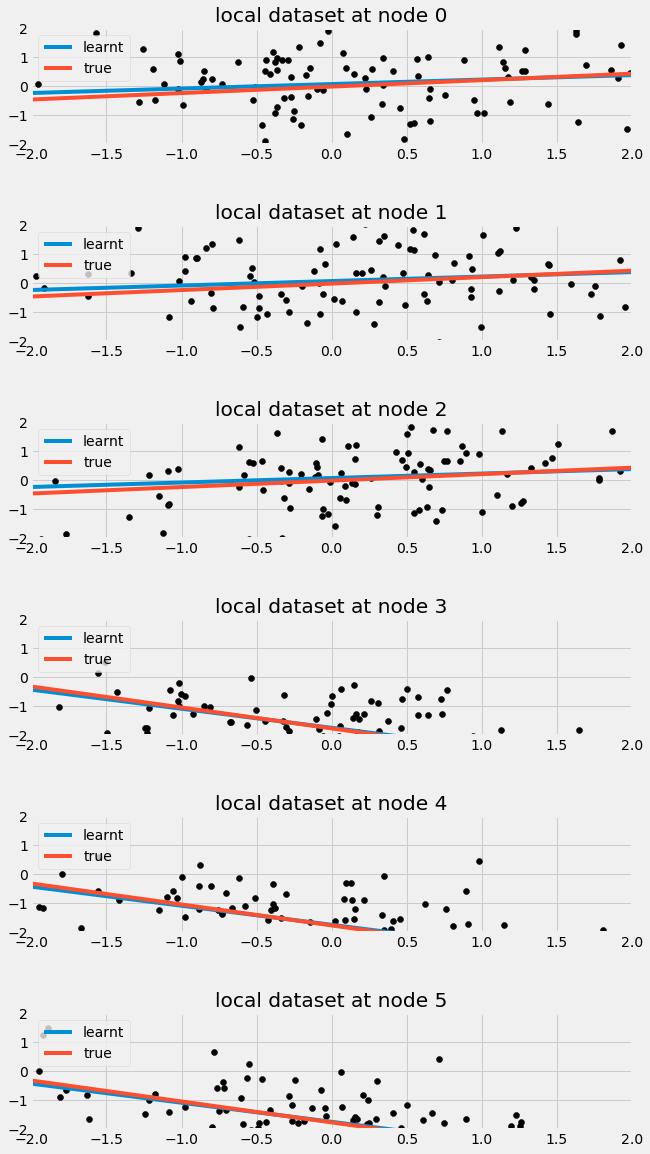

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(G.nodes),figsize=(10,17))
plt.style.use('fivethirtyeight')
    
X_grid = np.hstack((np.linspace(-2.0, 2.0, 100).reshape(-1,1),np.ones((100,1))))

for iter_node in G.nodes: 
    X = G.nodes[iter_node]["X"]
    y = G.nodes[iter_node]["y"]
    learnt_weights = G.nodes[iter_node]["weights"]
    txt="local dataset at node "+str(iter_node)
    axs[iter_node].set_ylim([-2, 2])
    axs[iter_node].set_xlim([-2, 2])
    axs[iter_node].title.set_text(txt)
    axs[iter_node].scatter(X[:,0], y, color='black')
    
    # illustrate the learnt weights by a straight line obtained by evaluating the 
    # corresponding linear predictor for a regular grid of feature values X_grid
    axs[iter_node].plot(X_grid[:,0], X_grid.dot(learnt_weights),label = "learnt")
    
    # illustrate the optimal predictor obtained from the ground truth weight vector
    axs[iter_node].plot(X_grid[:,0], X_grid.dot(true_weights[:,G.nodes[iter_node]["block"]]), label ="true")
    axs[iter_node].legend(loc='upper left')

plt.tight_layout(pad=3.0)
plt.show()